In [3]:
import os
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

from matplotlib import dates
import datetime

from heapq import nsmallest

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import seaborn as sns
from neuralprophet import NeuralProphet, set_log_level

import warnings

In [4]:
holidays=['2020-01-01','2020-01-06','2020-04-12','2020-04-13','2020-05-01','2020-05-03',
          '2020-05-31', '2020-06-11','2020-08-15','2020-11-01','2020-11-11','2020-12-25',
          '2020-12-26','2021-01-01','2021-01-06','2021-04-04','2021-04-05','2021-05-01',
          '2021-05-03','2021-05-23','2021-06-03','2021-08-15','2021-11-01','2021-11-11',
          '2021-12-25','2021-12-26', '2022-01-01','2022-01-06', '2022-04-01','2022-04-02','2022-04-03','2022-04-04','2022-04-05',
          '2022-04-27','2022-04-28','2022-04-29','2022-04-30',
          '2022-05-01', '2022-05-02','2022-05-03','2022-05-04',
          '2022-05-23','2022-06-03','2022-08-15','2022-11-01','2022-11-11',
          '2022-12-25','2022-12-26'
         ]

state = pd.DataFrame({'ds': pd.to_datetime(holidays),
                      'holiday': 'state_holiday'
                      })
holidays = state

In [131]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[:6] == 'zakupy']

In [132]:
df = pd.DataFrame()
for f in files_csv:
    data = pd.read_excel(f)
    df = df.append(data)

df.head(3)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)



,NumerZlecenia,LokalizacjaAkcji,LokalizacjaPoczatkowa,LokalizacjaKoncowa,CzasPrzejazdu,PrzebytyDystans,SredniaPredkosc,OcenaJazdyExpress,OcenaPredkosciExpress,OcenaOgolnaExpress,...,SamochodId.1,NumerRejestracyjny.1,Subsystem.1,Stan.1,DataDodania.1,Uwagi.1,SklepTrafiszopId.1,NazwaSklepu.1,AdresSklepu.1,MiastoSklepu.1
0,ZTF/90439/2022,Warszawa,"Warszawa, ul. Bokserska 64 - 24h Carrefour Ark...","Warszawa, ul. Bokserska 64 - 24h ul. Kolska 11...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF/90440/2022,Białystok,Białystok Wrocławska 20 Białystok,Białystok ul. Wołodyjowskiego 1/Szpital Tymcza...,0.5038,10.0,19.85,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF/90441/2022,Gdańsk,"Gdańsk, ul. Budowlanych 67 Schuberta 102 A Gd...","Gdańsk, ul. Budowlanych 67 ul. Mikołaja Reja 3...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
df=df.reset_index()
del df['index']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195584 entries, 0 to 195583
Data columns (total 74 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   NumerZlecenia                   195584 non-null  object 
 1   LokalizacjaAkcji                194665 non-null  object 
 2   LokalizacjaPoczatkowa           195583 non-null  object 
 3   LokalizacjaKoncowa              195583 non-null  object 
 4   CzasPrzejazdu                   872 non-null     float64
 5   PrzebytyDystans                 872 non-null     float64
 6   SredniaPredkosc                 872 non-null     float64
 7   OcenaJazdyExpress               872 non-null     float64
 8   OcenaPredkosciExpress           872 non-null     float64
 9   OcenaOgolnaExpress              872 non-null     float64
 10  NajwyzszaPredkosc               872 non-null     float64
 11  OcenaRezerwacjiCms              0 non-null       float64
 12  IdWsparciaCms   

In [136]:
#Lokalizacje akcji zapełnic miastem sklepu
df.LokalizacjaAkcji.fillna(df.MiastoSklepu, inplace=True)
#Wyrzucenie kolumn z brakiem DatyRozpoczęcia / data rozpoczęcia może wystąpić w następnych dniach od planowanej
df = df.dropna(subset=['DataRozpoczecia'])
df=df.reset_index()
del df['index']

In [137]:
# zmiana formatu daty na datetime
df['PlanowanaDataRozpoczecia']= pd.to_datetime(df['PlanowanaDataRozpoczecia'])
df['PlanowanaDataZakonczenia']= pd.to_datetime(df['PlanowanaDataZakonczenia'])
df['DataZakonczenia']= pd.to_datetime(df['DataZakonczenia'])
df['ZadeklarowanaData']= pd.to_datetime(df['ZadeklarowanaData'])
df['DataRozpoczecia']= pd.to_datetime(df['DataRozpoczecia'])
df['DataDodania']= pd.to_datetime(df['DataDodania'])

In [140]:
#Wyrzucenie kolumn gdzie data zakonczenia jest przed data rozpoczecia
# df = df[df['DataZakonczenia']>df['DataRozpoczecia']]
print(len(df))

193194


In [141]:
#Dodanie kolumny z numeryczna wartością dla dnia tygodnia(0-poniedziałek itd.)
#df['day_of_week'] = df['PlanowanaDataRozpoczecia'].dt.day_name() #wartość string
df['day_of_week'] = df['PlanowanaDataRozpoczecia'].dt.dayofweek #wartosć numeryczna
df['Lp'] = 1 

In [142]:
# usunięcie niedziel
df_weekdays = df[df['DataRozpoczecia'].dt.dayofweek < 6]
# df_weekdays = df
df_weekdays = df_weekdays.reset_index()
df_weekdays = df_weekdays.drop(columns=['index'])


In [143]:
# Lista miast
city_list = ['Kraków' 'Łódź' 'Katowice' 'Warszawa' 'Wrocław' 'Poznań' 'Gdańsk'
 'Chorzów' 'Białystok' 'Lublin' 'Gliwice' 'Szczecin' 'Sosnowiec'
 'Bielsko-Biała' 'Piotrków Trybunalski' 'Bytom' 'Jaworzno' 'Rybnik'
 'Wołomin' 'Radom' 'Mińsk Mazowiecki']

big_city_list = ['Warszawa', 'Kraków', 'Wrocław']

In [144]:
#Sprzedaż danego dnia tygodnia
data_sales_weekday = df.groupby(df['day_of_week']).agg({"Lp":"sum"})
#Sprzedaż w danych godzinach
data_sales_hour = df.groupby(df['DataRozpoczecia'].dt.hour).agg({"Lp":"sum"})
#Sprzedaż danego dnia miesiąca
data_sales_day = df.groupby(df['DataRozpoczecia'].dt.day).agg({"Lp":"sum"})
#Sprzedaż danego miesiąca
data_sales_month = df.groupby(df['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
#Sprzedaż danego roku
data_sales_year = df.groupby(df['DataRozpoczecia'].dt.year).agg({"Lp":"sum"})
#Sprzedaż w danych godzinach - Data zakończenia
data_sales_hour_z = df.groupby(df['DataZakonczenia'].dt.hour).agg({"Lp":"sum"})
#Sprzedaż danego tygodnia w roku
data_sales_week = df.groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/1539491939.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_sales_week = df.groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})



In [145]:
# podzial na miasta
df_warszawa = df.loc[df['MiastoSklepu'] == 'Warszawa']
df_krakow = df.loc[df['MiastoSklepu'] == 'Kraków']
df_wroclaw = df.loc[df['MiastoSklepu'] == 'Wrocław']

In [146]:
#podział na dni

date_sales = df.groupby(pd.to_datetime(df['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
warsaw_date_sales = df_warszawa.groupby(pd.to_datetime(df_warszawa['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
krakow_date_sales = df_krakow.groupby(pd.to_datetime(df_krakow['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
wroclaw_date_sales = df_wroclaw.groupby(pd.to_datetime(df_wroclaw['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})

In [149]:
# odszumianie danych - uzupelnianie dat pustych, lub o wartosci mniejszej niz
# 10% sredniej ilosci z danego miesiaca poprzez interpolacje "niemalymi"
# wartosciami z okolicznych dat

years = [2020, 2021, 2022]
idx = pd.date_range('2020-10-30', '2022-11-08')
wwa_idx = pd.date_range('2020-10-30', '2022-11-08')
krk_idx = pd.date_range('2020-10-30', '2022-11-08')
wr_idx = pd.date_range('2020-10-30', '2022-11-08')


year_sales_dict = {}
year_sales_dict_week = {}

year_sales_dict_wwa = {}
year_sales_dict_week_wwa = {}

year_sales_dict_wr = {}
year_sales_dict_week_wr = {}

year_sales_dict_krk = {}
year_sales_dict_week_krk = {}

date_sales_un = date_sales.reindex(idx, fill_value=0)
date_sales_un = date_sales_un.reset_index()

date_sales_wwa_un = warsaw_date_sales.reindex(idx, fill_value=0)
date_sales_wwa_un = date_sales_wwa_un.reset_index()

date_sales_krk_un = krakow_date_sales.reindex(idx, fill_value=0)
date_sales_krk_un = date_sales_krk_un.reset_index()

date_sales_wr_un = wroclaw_date_sales.reindex(idx, fill_value=0)
date_sales_wr_un = date_sales_wr_un.reset_index()

date_sales_un = date_sales_wwa_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_wwa_un = date_sales_wwa_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_krk_un = date_sales_krk_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_wr_un = date_sales_wr_un.rename(columns={'index': 'ds', 'Lp': 'y'})

if 'DataRozpoczecia' in date_sales_un.columns.values.tolist():
    date_sales_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_wwa_un.columns.values.tolist():
    date_sales_wwa_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_krk_un.columns.values.tolist():
    date_sales_krk_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_wr_un.columns.values.tolist():
    date_sales_wr_un.drop(['DataRozpoczecia'], axis=1)

for year in years:
    year_sales_dict[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})
    
    year_sales_dict_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    year_sales_dict_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_krakow['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_krakow['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    year_sales_dict_wr[year]=df_wroclaw[df_wroclaw['DataRozpoczecia'].dt.year == year].groupby(df_wroclaw['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_wr[year]=df_wroclaw[df_wroclaw['DataRozpoczecia'].dt.year == year].groupby(df_wroclaw['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    
for key, value in year_sales_dict.items():
    value = value.to_dict()['Lp']
    year_sales_dict[key] = value
    
for key, value in year_sales_dict_week.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week[key] = value
    
for key, value in year_sales_dict_wwa.items():
    value = value.to_dict()['Lp']
    year_sales_dict_wwa[key] = value
    
for key, value in year_sales_dict_week_wwa.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_wwa[key] = value
    
for key, value in year_sales_dict_krk.items():
    value = value.to_dict()['Lp']
    year_sales_dict_krk[key] = value
    
for key, value in year_sales_dict_week_krk.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_krk[key] = value
    
for key, value in year_sales_dict_wr.items():
    value = value.to_dict()['Lp']
    year_sales_dict_wr[key] = value
    
for key, value in year_sales_dict_week_wr.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_wr[key] = value
    
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict[year][month]/30
    
    if week in year_sales_dict_week[year].keys():
        avg_week_sales = year_sales_dict_week[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_un.at[index, 'y'] = int(avg_week_sales)
        
#     odszumienie zbioru danych dla warszawy
            
for index, row in date_sales_wwa_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_wwa[year][month]/30
    
    if week in year_sales_dict_week_wwa[year].keys():
        avg_week_sales = year_sales_dict_week_wwa[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_wwa_un.at[index, 'y'] = int(avg_week_sales)

        
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_krk_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_krk[year][month]/30
    
    if week in year_sales_dict_week_krk[year].keys():
        avg_week_sales = year_sales_dict_week_krk[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_krk_un.at[index, 'y'] = int(avg_week_sales)

        
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_wr_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_wr[year][month]/30
    
    if week in year_sales_dict_week_wr[year].keys():
        avg_week_sales = year_sales_dict_week_wr[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_wr_un.at[index, 'y'] = int(avg_week_sales)


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/3106878363.py:55: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/3106878363.py:58: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/3106878363.py:61: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_kr

In [150]:
# przygotowanie danych dla modelu prophet
prepared_date_sales = date_sales_un
prepared_wroclaw_date_sales = date_sales_wr_un
prepared_krakow_date_sales = date_sales_krk_un
prepared_warszawa_date_sales = date_sales_wwa_un

prepared_date_sales.set_index('ds')
# prepared_date_sales['ds'] = prepared_date_sales.index
# prepared_date_sales = prepared_date_sales.reset_index()
# print(prepared_date_sales.head(1)['ds'].to_numpy()[0].weekday())


# # usuniecie niedziel
# prepared_date_sales = prepared_date_sales[prepared_date_sales['ds'].to_numpy()[0].weekday() < 6]
# prepared_date_sales=prepared_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_date_sales=prepared_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_wroclaw_date_sales['ds'] = prepared_wroclaw_date_sales.index
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.reset_index()
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_krakow_date_sales['ds'] = prepared_krakow_date_sales.index
# prepared_krakow_date_sales = prepared_krakow_date_sales.reset_index()
# prepared_krakow_date_sales = prepared_krakow_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_krakow_date_sales = prepared_krakow_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_warszawa_date_sales['ds'] = prepared_warszawa_date_sales.index
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.reset_index()
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_warszawa_date_sales.head(20)

,y
ds,
2020-10-30,4
2020-10-31,36
2020-11-01,17
2020-11-02,54
2020-11-03,35
...,...
2022-11-04,139
2022-11-05,72
2022-11-06,81


In [151]:
# train datasets for cities
train_3, train_7, train_30, train_120 = [], [], [], []

# Poland
train_3 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-3:])
train_7 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-7:])
train_30 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-30:])
train_120 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-120:])


# Warszawa
wwa_train_3 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-3:])
wwa_train_7 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-7:])
wwa_train_30 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-30:])
wwa_train_120 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-120:])

wwa_train_last_10 = prepared_warszawa_date_sales.tail(10)
wwa_train_last_30 = prepared_warszawa_date_sales.tail(30)
wwa_train_last_60 = prepared_warszawa_date_sales.tail(60)
wwa_train_last_100 = prepared_warszawa_date_sales.tail(100)

# Krakow
krk_train_3 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-3:])
krk_train_7 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-7:])
krk_train_30 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-30:])
krk_train_120 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-120:])

krk_train_last_10 = prepared_krakow_date_sales.tail(10)
krk_train_last_30 = prepared_krakow_date_sales.tail(30)
krk_train_last_50 = prepared_krakow_date_sales.tail(50)
krk_train_last_100 = prepared_krakow_date_sales.tail(100)

# Wroclaw
wr_train_3 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-3:])
wr_train_7 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-7:])
wr_train_30 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-30:])
wr_train_120 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-120:])

wr_train_last_10 = prepared_wroclaw_date_sales.tail(10)
wr_train_last_30 = prepared_wroclaw_date_sales.tail(30)
wr_train_last_50 = prepared_wroclaw_date_sales.tail(50)
wr_train_last_100 = prepared_wroclaw_date_sales.tail(100)


prepared_warszawa_date_sales.head(20)

,ds,y
0,2020-10-30,4
1,2020-10-31,36
2,2020-11-01,7
3,2020-11-02,54
4,2020-11-03,35
5,2020-11-04,37
6,2020-11-05,69
7,2020-11-06,86
8,2020-11-07,87
9,2020-11-08,62


In [152]:
def quality_metrics(y, y_hat):
    print('MAE:', np.mean(np.abs(y - y_hat)))
    print('RMSE:', np.sqrt(np.mean(np.square(y - y_hat))))
    print('MAPE:', np.mean(np.abs((y - y_hat)/y)*100))
    print('MAX:', np.max(np.abs(y - y_hat)))
    mae = np.mean(np.abs(y - y_hat))
    rmse = np.sqrt(np.mean(np.square(y - y_hat)))
    mape = np.mean(np.abs((y - y_hat)/y)*100)
    maxi = np.max(np.abs(y - y_hat))
    return ([mae, rmse, mape, maxi])

In [158]:
# Neural Prophet model 3
neural_model_3 = NeuralProphet(
    growth='off',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=7,
#     n_forecasts=7,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.05,
    epochs=100,
#     seasonality_mode = 'multiplicative',
#     ar_reg=1,
)
# neural_model_3.add_seasonality(name='2_prediction_horizon', period=14, fourier_order=3)

neural_model_3.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [94]:
# Neural Prophet model 2
neural_model_2 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=7,
#     n_forecasts=30,
#     ar_reg=1,
    num_hidden_layers=2,
#     num_hidden_layers=1,
    d_hidden=64,
    learning_rate = 0.05,
    epochs = 100,
#     seasonality_mode = 'multiplicative',
)

# neural_model_1.add_seasonality(name='2_prediction_horizon', period=14, fourier_order=3)
# neural_model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)
neural_model_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)

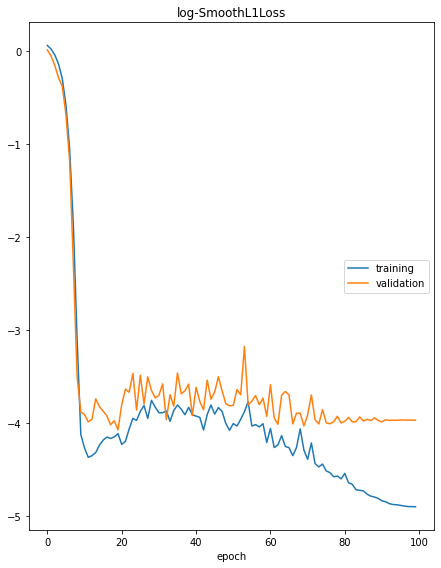

log-SmoothL1Loss
	training         	 (min:   -4.898, max:    0.057, cur:   -4.898)
	validation       	 (min:   -4.071, max:    0.008, cur:   -3.968)


In [159]:
# m = neural_model_1
# m = neural_model_2
m = neural_model_3

# df_train, df_test = m.split_df(wwa_train_last_100.drop(wwa_train_last_100.index[-7:]), freq='D', valid_p = 0.2)

df_train, df_test = m.split_df(wwa_train_3, freq='D', valid_p = 0.2)

metrics = m.fit(df_train, 
                freq='D', 
                validation_df=df_test, 
                progress='plot')
# metrics = m.fit(wwa_train_7, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.865% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.865% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



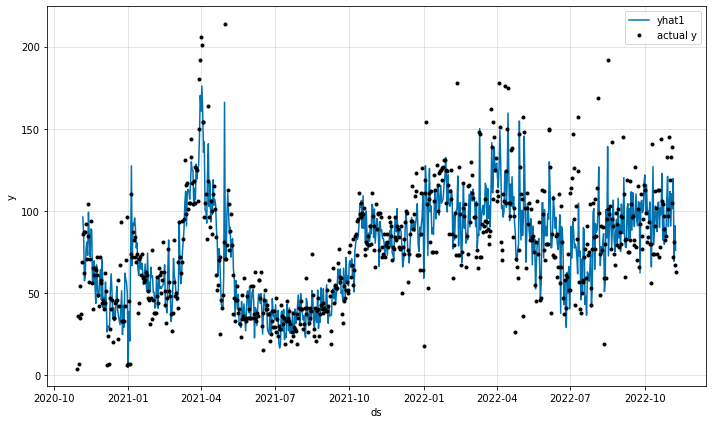

In [160]:
# Neural Prophet model prediction
forecast = m.predict(prepared_warszawa_date_sales)
fig = m.plot(forecast)

In [161]:
# real = prepared_warszawa_date_sales['y'].values[-500:] #bez niedziel
# pred = forecast['yhat1'].values[-500:] 
# print(pred)

real = prepared_warszawa_date_sales['y'].values #bez niedziel
pred = forecast['yhat1'].values 

# print("Metrics for whole training period")
# quality_metrics(real, pred)

print("Metrics for last 3 days")
quality_metrics(real[-7:], pred[-7:])

# print(prepared_warszawa_date_sales.head(15))
# # print(forecast.head(15))

# print(prepared_warszawa_date_sales.tail(30))
# print(forecast[['yhat1', 'ds']].tail(30))


# model_1.plot(forecast);

Metrics for last 3 days
MAE: 25.955630711146764
RMSE: 30.212008998154758
MAPE: 28.748294975168058
MAX: 47.77528381347656


[25.955630711146764, 30.212008998154758, 28.748294975168058, 47.77528381347656]

In [162]:
# anomaly detection
anomalies_dict = {}
threshold = 0.05

while threshold < 1:
    anomalies = []
    for i in range (1, len(pred)-2):
        pred_v = pred[len(pred)-i]
        real_v = real[len(real)-i]
        if pred_v is None:
            anomalies_dict[threshold] = anomalies
            break
        if abs(real_v - pred_v) > threshold * real_v:
            anomalies.append(i)
            anomalies_dict[threshold] = anomalies
    threshold += 0.05
    threshold = round(threshold, 2)


for key, value in anomalies_dict.items():
    print(str(key) + ": " + str(len(value)))
    

0.05: 616
0.1: 460
0.15: 354
0.2: 271
0.25: 196
0.3: 155
0.35: 112
0.4: 84
0.45: 64
0.5: 56
0.55: 47
0.6: 34
0.65: 28
0.7: 24
0.75: 16
0.8: 15
0.85: 14
0.9: 12
0.95: 11


740


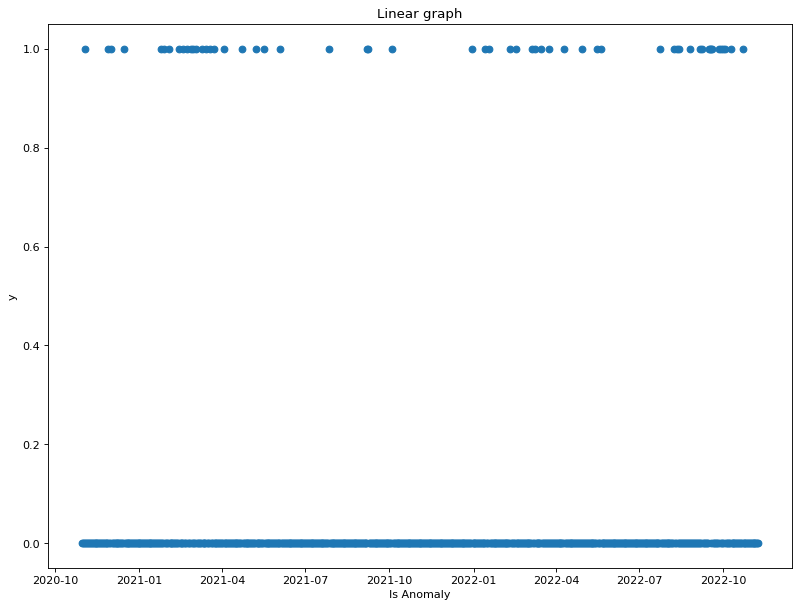

In [179]:
# Laczenie anomalii z datami
print(len(pred))

# prog anomalii
th = 0.5

anomaly_existance_list = [0] * len(pred)
for anomaly in anomalies_dict[th]:
    anomaly_existance_list[anomaly] = 1

date_anomaly_df = pd.DataFrame()
date_anomaly_df['ds'] = prepared_warszawa_date_sales['ds']
date_anomaly_df['if_anomaly'] = anomaly_existance_list

date_anomaly_df.head()

plt.figure(figsize=(12, 9), dpi=80)
plt.scatter(date_anomaly_df['ds'], date_anomaly_df['if_anomaly'])
plt.xlabel('Is Anomaly') 
plt.ylabel('y') 
# displaying the title
plt.title("Linear graph")
plt.show() # Depending on whether you use IPython or interactive mode, etc.

    

# prepared_warszawa_date_sales.info()

In [180]:
# daty w ktorych wystepuja anomalie
is_anomaly_dates_df = date_anomaly_df.loc[date_anomaly_df['if_anomaly'] == 1]
is_anomaly_dates_df['weekday'] = is_anomaly_dates_df['ds'].dt.dayofweek #wartosć numeryczna
is_anomaly_dates_df = is_anomaly_dates_df.drop(columns=['if_anomaly'])


print(is_anomaly_dates_df.head(70))

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_4663/3002214443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_anomaly_dates_df['weekday'] = is_anomaly_dates_df['ds'].dt.dayofweek #wartosć numeryczna



            ds  weekday
4   2020-11-03        1
29  2020-11-28        5
32  2020-12-01        1
46  2020-12-15        1
87  2021-01-25        0
90  2021-01-28        3
95  2021-02-02        1
106 2021-02-13        5
111 2021-02-18        3
115 2021-02-22        0
119 2021-02-26        4
122 2021-03-01        0
125 2021-03-04        3
131 2021-03-10        2
136 2021-03-15        0
140 2021-03-19        4
144 2021-03-23        1
155 2021-04-03        5
175 2021-04-23        4
190 2021-05-08        5
199 2021-05-17        0
217 2021-06-04        4
270 2021-07-27        1
312 2021-09-07        1
313 2021-09-08        2
339 2021-10-04        0
426 2021-12-30        3
441 2022-01-14        4
445 2022-01-18        1
468 2022-02-10        3
474 2022-02-16        2
492 2022-03-06        6
495 2022-03-09        2
502 2022-03-16        2
511 2022-03-25        4
527 2022-04-10        6
547 2022-04-30        5
563 2022-05-16        0
567 2022-05-20        4
632 2022-07-24        6
647 2022-08-08  